# Variants of stochastic gradient-based optimization

## Steps

1. Setting the scene
2. Stochastic Gradient Descent (SGD) *(not implemented)*
3. SGD with adaptive learning rate *(implemented and optimized using grid search)*
4. SGD with adaptive learning rate *(implemented and optimized using random search)*

## Setting the scene

During learning, we optimize the mean squared error $MSE$ of the models $m$ for the model parameters $\mathbf w$: 

$$MSE(\mathbf w,m,X,Y) =\frac{1}{N}\sum_{i=1}^{N}(y_i - m(\mathbf w, \mathbf  x_i))^2$$

In other words, we find $\arg\min_{\mathbf w} MSE(\mathbf w, m, X, Y)$.

We will reuse some functions defined in the notebook "Learn an XOR Neural Network using gradient-based optimization" including:
1. The mean squared error function `mse` (loss function).
2. The gradient of the mean squared error function `grad_mse` (gradient of the loss function).
3. The gradient descent function for the loss function `grad_desc_mse`.
4. The 3D surcace and contour plot function `plot3D`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def mse(ws, m, X, Y):
    N = len(X)
    err = 0
    for i in range(N):
        y_hat = m(ws, X[i])
        err += (Y[i] - y_hat)**2
    return err / N

def grad_mse(ws, m, grads, X, Y):
    N = len(X)
    M = len(ws)
    grad_ws = np.zeros((M))
    for i in range(N):
        xi = X[i,:]
        yi = Y[i]
        tmp = yi - m(ws, xi)
        for j in range(M):
            grad_ws[j] = grad_ws[j] + tmp*grads[j](ws, xi)
    grad_ws = grad_ws / -2
    return grad_ws

def grad_desc_mse(K, ws, learning_eps, loss, grad_loss, verbose):
    hist = np.zeros((K+1))
    hist[0] = loss(ws)
    for k in range(K):
        grad_ws = grad_loss(ws)
        old_ws = ws
        ws = old_ws - learning_eps * grad_ws
        if verbose:
            plt.plot([old_ws[0], ws[0]], [old_ws[1], ws[1]])

        hist[k+1] = loss(ws)
    return ws, hist

def plot3d(f,A,B,real3d):
    vectorized_func = np.vectorize(f)
    Z = vectorized_func(A,B)
    if real3d:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(A, B, Z, cmap='viridis')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.invert_xaxis() 
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        surf = ax.contour(A, B, Z, cmap='viridis')
        fig.colorbar(surf, shrink=0.5, aspect=5)
    return fig, ax



First we generate sample data points. The generator function is $y=20x_1 -3x_2$. We sample data at integer points $x_{i,1}\times x_{i,2} \in [1\ldots N]\times [1\ldots N], N=100$ and add a random error to $y_i$ that is normally distributed proportional to $\mathcal{N}(0,10)$. 

Below we plot the function.

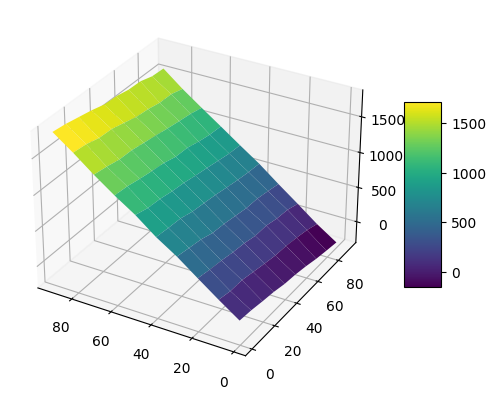

In [2]:
N = 100
XX = np.array(np.meshgrid(np.arange(1,N+1), np.arange(1,N+1))).T.reshape(-1, 2)
a10 = 20
a20 = -3

X1 = XX[:,0]
X2 = XX[:,1]

f0 = lambda x1, x2: a10*x1 + a20*x2
f = lambda x1,x2,r: a10*x1 + a20*x2 + r

np.random.seed(42)
R = np.transpose(np.random.normal(0, 10, len(XX)))
Y = np.vectorize(f)(X1,X2,R)
A,B = np.meshgrid(np.arange(1, N+1, N/10), np.arange(1, N+1, N/10))
ff = lambda x1,x2: f(x1,x2,np.random.normal(0, 10))

plot3d(ff, A,B, True)
plt.show()

The model that we use throughout this notebook is a simple linear Neural Network model. It consists of one neuron connected to the input $\mathbf x$ and an identity, i.e., no effective, activation function. The neuron and the whole model $m_1$ implements $m_1(\mathbf w, \mathbf x) = \mathbf w^T \mathbf x$.

In [3]:
m1 = lambda ws,x: ws[0] * x[0] + ws[1] * x[1]
mse1 = lambda ws: mse(ws, m1, XX, Y)

As the Tensorflow default, we implement the Glorot uniform initializer for setting the initial weights $\mathbf w_0$.
It draws samples from a uniform random distribution within $[-\mathit{limit}, \mathit{limit}]$,
where $\mathit{limit} = \sqrt{\frac{6}{\mathit{in} + \mathit{out}}}$, and
where $\mathit{in}$ and $\mathit{out}$ is the number of input and output units, resp.

In [4]:
import math 
import random

random.seed(42)
input = 2
out = 2
limit = math.sqrt(6 / (input + out))
ws0 = [random.uniform(-limit, limit), random.uniform(-limit, limit)]
print(ws0)

[0.3415245126916837, -1.1634812830144055]


We assess the loss $MSE$ of $m_1$ for this initial weights setting.

In [5]:
mse1(ws0)

1134789.243254444

The gradient of $MSE(\mathbf w)$ for any $\mathbf w$ is defiend as:

$$
\begin{aligned}
\nabla_{MSE}(\mathbf w) &= \left [ 
\frac{\partial MSE(\mathbf w)}{\partial w_1},
\frac{\partial MSE(\mathbf w)}{\partial w_2}
\right ]^T\\
&= \frac{1}{N}\left [ 
\frac{\partial \sum_{i=1}^{N}(y_i - m_1(\mathbf w,\mathbf x_i)^2}{\partial w_1}, 
\frac{\partial \sum_{i=1}^{N}(y_i - m_1(\mathbf w,\mathbf x_i))^2}{\partial w_2} 
\right ]^T \\
&= \frac{1}{N} \left [ 
\sum_{i=1}^{N}2(y_i- m_1(\mathbf w,\mathbf x_i))\frac{-\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1},
\sum_{i=1}^{N}2(y_i- m_1(\mathbf w,\mathbf x_i))\frac{-\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2}
\right ]^T \\
&= -\frac{2}{N} \left [ 
\sum_{i=1}^{N}(y_i- m_1(\mathbf w,\mathbf x_i))\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1},
\sum_{i=1}^{N}(y_i- m_1(\mathbf w,\mathbf x_i))\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2}
\right ]^T \\
\end{aligned}
$$

We can plug in the function $m_1$ and the first derivative of $m_1$ wrt. $w_1$ and $w_2$ resp.

$$
\begin{aligned}
\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_1} &=\frac{\partial \mathbf w^T\mathbf x_{i}}{\partial w_1} = \frac{\partial w_1 x_{i,1} + w_2 x_{i,2}}{\partial w_1}  =x_{i,1}\\
\frac{\partial m_1(\mathbf w,\mathbf x_i)}{\partial w_2} &=\frac{\partial \mathbf w^T\mathbf x_{i}}{\partial w_2} = \frac{\partial w_1 x_{i,1} + w_2 x_{i,2}}{\partial w_2}  = x_{i,2}\\
\end{aligned}
$$

We have already defined the function $m_1$. Let's also define the functions of the first derivative of $m_1$ wrt. $w_1$ and $w_2$ resp. For the sake of generality, we keep $\mathbf w$ as a formal parameter `ws` even though it is actually not needed for  derivatives of this concrete model $m_1$. 

In [6]:
grad1 = lambda ws, x: x[0]
grad2 = lambda ws, x: x[1]
gradients1 = [grad1, grad2]

The gradient $\nabla_{MSE}(\mathbf w)$ has been defined using $m_1$ and the first derivative of $m_1$ wrt. $w_1$ and $w_2$, resp., as parameters.

The gradient descent function optimizes $\mathbf w$ by iterating over:

$$\mathbf w_{k+1}= \mathbf w_k - \varepsilon \nabla_{MSE}(\mathbf w_k)$$

staring with $\mathbf w_0$.

Below we apply the gradient descent function minimizing $MSE$ for the model $m_1$. We plot the $MSE$ for each step $k$ in the iteration as a function of the current parameter setting $\mathbf w_k$. We also marked the starting point $\mathbf w_0$ with a `+` and the (ideal) minimum $(20, -3)$ with a `*`.

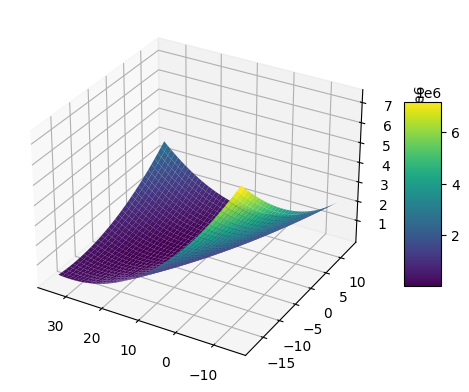

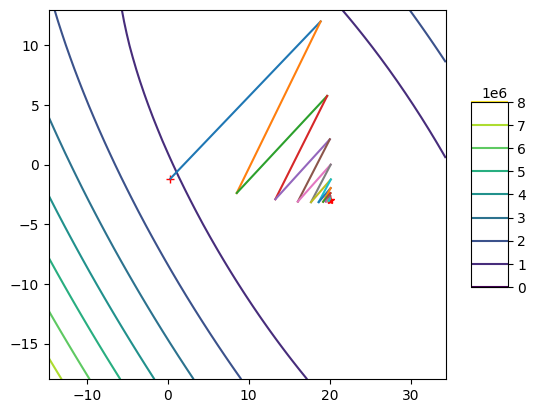

In [7]:
f = lambda a,b : mse1([a,b])

A,B = np.meshgrid(np.arange(min(a10, ws0[0])-15, max(a10,ws0[0])+15), np.arange(min(a20, ws0[1])-15, max(a20,ws0[1])+15))
plot3d(f,A,B, True)
plt.show()

plot3d(f, A, B, False)

plt.plot(a10, a20,'*r')
plt.plot(ws0[0], ws0[1],'+r')

#gradient descent
grad_loss = lambda ws: grad_mse(ws, m1, gradients1, XX, Y)
K = 20
learning_eps = 0.00000006 # needed to change the learning rate. Otherwise I got the problem of overshooting steps.
[ws, history] = grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss, True)



# *Original approach with two hyper-parameters using an orginary grid search*

## SGD with adaptive learning rate

In [8]:
# SGD
grad_loss2 = lambda ws, randinces: grad_mse(ws, m1, gradients1, XX[randinces, :], Y[randinces])

The learning rate $\varepsilon$ is adapted in each iteration, e.g., exponentially by $\varepsilon_{k+1} = (1-\alpha)\varepsilon_{k}$ with $\alpha$ a new hyper-parameter. 

In [9]:
def stochastic_adaptive_grad_desc_mse(K, ws, learning_eps, loss, grad_loss, N, alpha, verbose):
    batch_size = int(N*0.01)
    hist = np.zeros((K+1))
    hist[0] = loss(ws)
    for k in range(K):
        randices = np.random.choice(np.arange(0, N), size=batch_size, replace=False)
        grad_ws = grad_loss(ws, randices)
        old_ws = ws
        ws = old_ws - learning_eps * grad_ws
        learning_eps = (1-alpha) * learning_eps
        if verbose:
            plt.plot([old_ws[0], ws[0]], [old_ws[1], ws[1]])
        hist[k+1] = loss(ws)
    return ws, hist

*Now I need to define a grid based approach to search for the optimal hyper-parameters. When tuning the hyper-parameter for a model I should consider cross validation. However, I assume that this excercise is about the advantages and disadvantages of the optimization strategies. Therefore, I neglected cross validataion and performed an ordinary grid search.*

In [10]:

param_grid = {
    'learning_eps': [6e-5, 3e-5, 1e-5, 8e-6, 7e-6, 6e-6, 5e-6, 3e-6, 1e-6, 8e-7, 6e-7],
    'alpha': [1e-5,3e-5,1e-4,3e-4,1e-3,3e-3,1e-2,3e-2]
}

best_score = 10000000
best_params = None

for learning_eps in param_grid['learning_eps']:
    for alpha in param_grid['alpha']:
        np.random.seed(42) # to be fair with the selection of mini batches in the whole search space
        [ws, history] = stochastic_adaptive_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, len(XX), alpha, False)
        
        score = mse1(ws)
        if score < best_score:
            best_score = score
            best_params = {'learning_eps': learning_eps, 'alpha': alpha}

print(best_params)
print(best_score)



{'learning_eps': 6e-06, 'alpha': 1e-05}
109.2116509274781


*Here, the optimal hyper-parameter according to my search are:*
- $\varepsilon = 6e-6$
- $\alpha = 0.00001$

*Now I plugged it into the algorithm again and plotted the history of the search and the learning rate.*

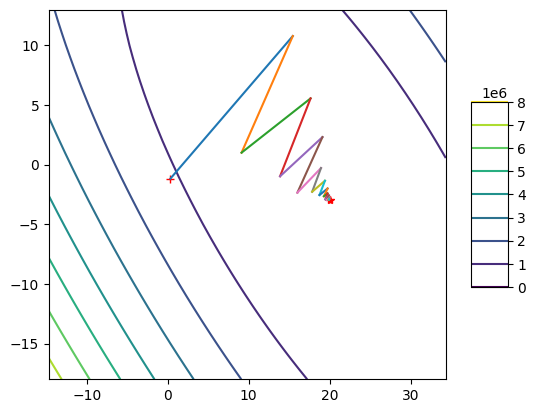

In [11]:
plot3d(f, A, B, False)
plt.plot(a10, a20,'*r')
plt.plot(ws0[0], ws0[1],'+r')

[ws, history1] = stochastic_adaptive_grad_desc_mse(K, ws0, best_params['learning_eps'], mse1, grad_loss2, len(XX), best_params['alpha'], True)


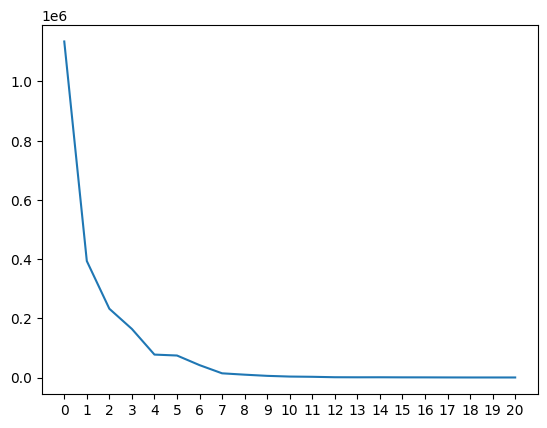

In [12]:
plt.plot(range(len(history1)), history1)
plt.xticks(range(len(history1)))
plt.show()

# *Now with advanced optimization approach*

*I decided to choose random search performed with 1000 iterations. The scope of parameters was not changed.*

In [13]:
from scipy.stats import uniform
from tqdm import tqdm

def sample_params(param_dist, random_state):
    params = {}
    for key, dist in param_dist.items():
        params[key] = dist.rvs(random_state = random_state)
    return params

param_dist = {
    'learning_eps': uniform(6e-7,6e-5),
    'alpha': uniform(1e-5,3e-2)
}

n_iter = 1000
best_score = 10000000
best_params = None

for i in tqdm(range(n_iter)):
    params = sample_params(param_dist, i)
    learning_eps = params['learning_eps']
    alpha = params['alpha']
    np.random.seed(42) # to be fair with the selection of mini batches in the whole search space
    [ws, history] = stochastic_adaptive_grad_desc_mse(K, ws0, learning_eps, mse1, grad_loss2, len(XX), alpha, False)
    
    score = mse1(ws)
    if score < best_score:
        best_score = score
        best_params = {'learning_eps': learning_eps, 'alpha': alpha}

print(best_params)
print(best_score)



100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s]

{'learning_eps': 6.18649720031148e-06, 'alpha': 0.0028032486001557397}
110.2136741319373


*Here, the optimal hyper-parameter according to my random search are:*
- $\varepsilon = 6.18649720031148e-6$
- $\alpha = 0.0028032486001557397$

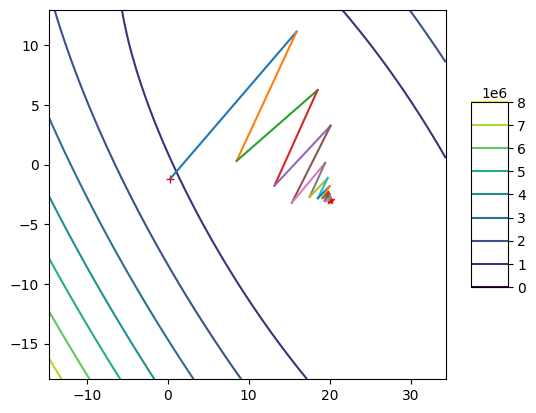

In [14]:
plot3d(f, A, B, False)
plt.plot(a10, a20,'*r')
plt.plot(ws0[0], ws0[1],'+r')

[ws, history2] = stochastic_adaptive_grad_desc_mse(K, ws0, best_params['learning_eps'], mse1, grad_loss2, len(XX), best_params['alpha'], True)


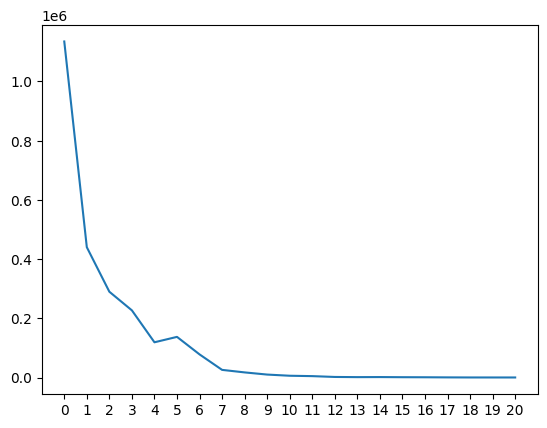

In [15]:
plt.plot(range(len(history2)), history2)
plt.xticks(range(len(history2)))
plt.show()

# *Comparison*

*Here I plotted the learning rates of the two approaches choosen in one diagram*

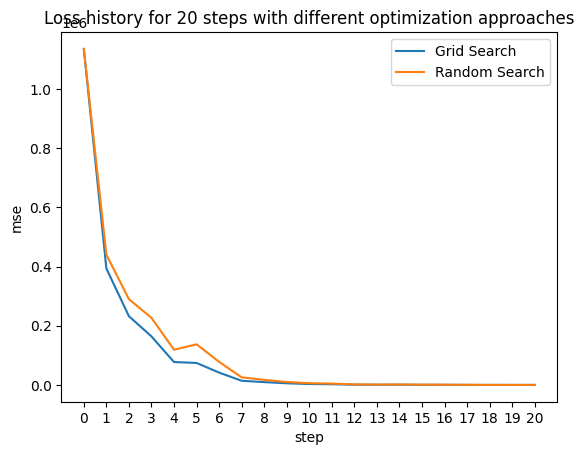

In [16]:
plt.plot(range(len(history1)), history1, label='Grid Search')
plt.plot(range(len(history2)), history2, label='Random Search')
plt.title('Loss history for 20 steps with different optimization approaches')
plt.legend()
plt.ylabel('mse')
plt.xlabel('step')
plt.xticks(range(len(history2)))
plt.show()

### *Interpretation*

*One can see, that the trajectory of the loss curve is more direct/steeper with the parameters found in grid search approach. Especially in step 1 to 8, the gradient decent with parameters found in random search made wider steps. Hence, the flatter trajectory of the loss curve.*

*Additionally, the random search did not find a set of parameters coming with a lower loss than with the grid search approach, i.e. random search: 110.21, and grid search: 109.21. However, the random search ran for 1000 iterations and took, therefore, longer than the grid search, where 88 iterations were needed.*

*So, in the end, it might be more reasonable to test specific parameter settings in a grid, when having just a few parameters. In cases, when there are more parameters, it might be helpful to ran a random search to get an idea of suitable settings of the parameters and, thus, narrow down the value space for each of them. After that, a grid search might lead to better insights about parameter values, since one knows the tested parameters, which is not the case in random search (unless you log them). Also if one has no clue about a reasonable value of a hyper-parameter, random search and other advanced techniques could help to narrow down the reasonable value scope for several parameters, before setting up intended values in a grid search.*  
